In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
import os
import cv2 
from PIL import Image 
    
#Import My Library
My_Package_PATH = "/home/boris/Documents/Research/Coding"
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, My_Package_PATH)
#from OneD import *

import OneD.Waves.NonDim as ND
import OneD.NBody.NBody as NB
import OneD.Global.GlobalFuncs as GF

#Set up Directory for saving files/images/videos
# Will not rename this again

Directory = "/home/boris/Documents/Research/Coding/1D codes/Non-Dim"

In [2]:
############################################
# Set up shared by Wave and N-Body scenarios
############################################
Num_particles = 1000

#Set scales and parameters:
L = 1
G = 1
hbar = 1
print("Enter the particle mass: ")
m = float(input())
print(f"Mass = {m}")

print(f"Length scale = {L}")

v = np.sqrt(4*np.pi*G*m/L)
print(f"Velocity scale = {v}")

T = L/v
print(f"Time scale = {T}")

r = ND.r(hbar,m,v,L)

#Set up Grid
N = 5*10**2
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]


Enter the particle mass: 
Mass = 5.0
Length scale = 1
Velocity scale = 7.926654595212022
Time scale = 0.126156626101008


## Wave Scenario

From the above scales, we can retrieve physical (dimensional) values from non-dimensionalized counterparts:
$$
\begin{cases}
\Phi \leftarrow v^2 \varphi \\
\psi \leftarrow L^{-3/2} \chi \\
x \leftarrow L z \\
t \leftarrow T \tau

\end{cases}
$$

So, set up is to create initial conditions directly in non-dimensional form, instead of making dimensional initial conditions to non-dimensionalize before running code.

The dimensional Schrodinger-Poisson system is:
$$
\begin{cases}
i\hbar \partial_{t} \psi = -\frac{\hbar^2}{2m}\nabla_{x}^2 \psi + m\Phi \psi 
\\
\nabla_{x}^2 \Phi = 4\pi G m (|\psi|^2-<|\psi|^2>)

\end{cases}
$$

Fixing a Length scale $L$, then defining a velocity scale:
$$v \equiv \sqrt{\frac{4\pi G m}{L}}$$
we can define a time-scale:
$$T \equiv \frac{L}{v}$$

Further defining a "fuzzy-ness" parameter:
$$r \equiv \frac{\hbar}{2mvL}$$

we can make the subsitutions for the non-dimensional values above to get a fully non-dimensional Schordinger-Poisson system:
$$
\begin{cases}
i \partial_{\tau} \chi = -r\nabla_{z}^2 \chi + \frac{1}{2r}\varphi \chi 
\\
\nabla_{z}^2 \varphi = |\chi|^2-<|\chi|^2>

\end{cases}
$$

We can further make things easier by letting:
$$\chi \rightarrow \frac{\chi}{\texttt{\# Particles}}$$

To then retrieve the density:
$$ \rho  = m(\text{\# Particles})|\chi|^2 = M |\chi|^2$$
where $M$ denotes the total mass.

In [3]:
#Set an initial wavefunction
b=0
std=0.1*L
psi = np.sqrt(GF.gauss(z,b,std)*Num_particles)#*Num_particles / (L**3))
chi = psi*L**0.5

#Calculate initial Density perturbation (non-dimensionalized and reduced)
rho = np.absolute(psi)**2 #just norm-squared of wavefunction
rho_avg = np.mean(rho)
P = rho-rho_avg

#Calculate initial (non-dim) potential
phi = ND.fourier_potential(chi,L) 

#storage space, with initial functions
P_s = np.array([P]) #initial density perturbation
chi_s = np.array([chi]) #initial wavefunction
phi_s = np.array([phi]) #initial potential [perturbation]

#Check how it's normalized:
print(np.sum(dz*np.absolute(chi)**2))
print(np.sum(dz*np.absolute(psi)**2))

#dt = 0.1
#t_stop = 20

dtau = 0.1*T
tau_stop = 5#t_stop/T
time = 0
while time <= tau_stop:
    ######################################
    #Evolve system forward by one time-step
    chi,phi,P = ND.time_evolve(chi,phi,r,dz,dtau,m,L)

    #phi = phi #* (L)
    ######################################

    #Append/store new arrays
    chi_s = np.append(chi_s,[chi], axis = 0)
    P_s = np.append(P_s, [P], axis = 0)
    phi_s = np.append(phi_s,[phi], axis = 0)

    time += dtau #forward on the clock

999.9994559933476
999.9994559933476


In [4]:
folder_name = "SelfGrav_Images"
GF.plot_save_waves(z,chi_s,phi_s,P_s,dtau,Num_particles,Directory,folder_name)
print("Plotting Done.")

Plotting Done.


In [5]:
folder_name = "SelfGrav_Images"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_name = f"SelfGrav_Mass{m}.mp4"
GF.animate(fourcc,Directory,folder_name,video_name,dtau)

In [6]:
! xdg-open "SelfGrav_Mass5.0.mp4"

Checking Normalization: 1.0


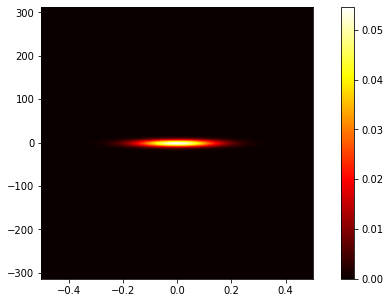

Checking Normalization: 1.0000000000000004


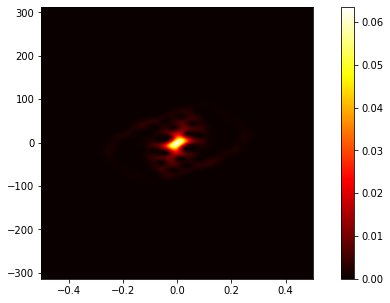

Checking Normalization: 1.0000000000000002


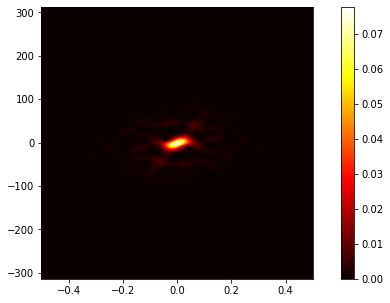

Checking Normalization: 1.0000000000000002


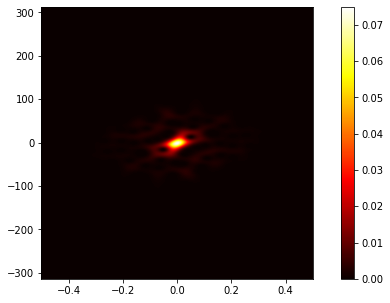

Checking Normalization: 1.0000000000000002


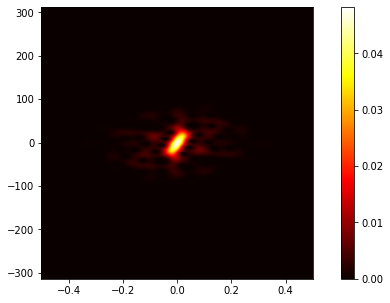

Checking Normalization: 0.9999999999999999


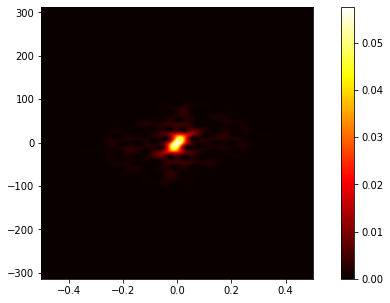

Checking Normalization: 1.0


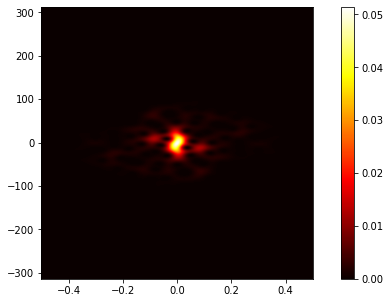

Checking Normalization: 0.9999999999999999


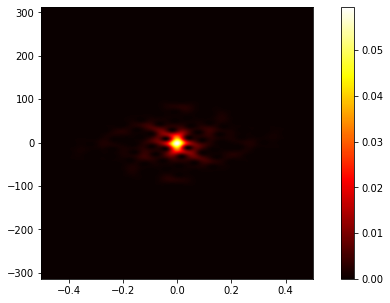

Checking Normalization: 1.0000000000000002


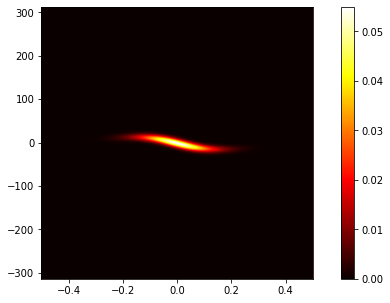

In [7]:
from matplotlib.colors import Normalize

k = 2*np.pi*np.fft.fftfreq(len(z),dz)
k = k/L #non-dimensionalize
dk = k[1]-k[0]

#rescale wavenumber k to velocity v:
v = k*(hbar/m)

x_min, x_max = np.min(z), np.max(z)
v_min, v_max = np.min(v), np.max(v)

psi_s = chi_s*L*(-0.5)
resolution = 0.025*L
for i in range(0,200,25):
    F = ND.Husimi_phase(psi_s[i],z,dz,L,resolution)
    print(f"Checking Normalization: {np.sum(dz*dk*F)}")
    #fig,ax = plt.subplots(1,1)
    plt.figure(figsize = (10,5))
    plt.imshow(F,extent = (x_min,x_max,v_min,v_max),cmap = cm.hot, aspect = x_max/v_max)
    plt.xlim([x_min,x_max])
    plt.ylim([v_min,v_max])
    plt.colorbar()
    plt.show()

F = ND.Husimi_phase(psi_s[1],z,dz,L,resolution)
print(f"Checking Normalization: {np.sum(dz*dk*F)}")
#fig,ax = plt.subplots(1,1)
plt.figure(figsize = (10,5))
plt.imshow(F,extent = (x_min,x_max,v_min,v_max),cmap = cm.hot, aspect = x_max/v_max)
plt.xlim([x_min,x_max])
plt.ylim([v_min,v_max])
plt.colorbar()
plt.show()

In [8]:
max_F = 0.05
frame_spacing = 1
folder_name = "SelfGrav_Phase_Images"
ND.generate_phase_plots(chi_s,z,dz,L,m,hbar,max_F,resolution,dtau,frame_spacing,Directory,folder_name)

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_name = "SelfGrav_Phase_video.mp4"
GF.animate(fourcc,Directory,folder_name,video_name,dtau)

In [10]:
! xdg-open "SelfGrav_Phase_video.mp4"

## N-Body Scenario

0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.00012640944499099012
0.0001264094449909901
0.00012640944499099012
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.00012640944499099012
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901
0.0001264094449909901


KeyboardInterrupt: 

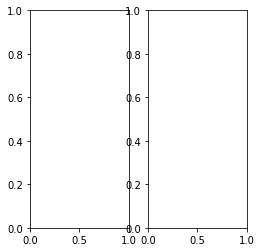

In [3]:
def accel_funct(a_grid,dz):
    def g(z):
        N = len(a_grid)
        j = int((z+L/2)//dz)
        rem = (z+L/2) % dz 
        value = 0
        if j < N-1:
            value = a_grid[j] + rem*(a_grid[j+1]-a_grid[j])/dz
        elif j == N-1:
            value = a_grid[-1]+rem*(a_grid[0]-a_grid[-1])/dz
        return value
    return g
def Chi(psi,L):
    return psi*L**0.5

Num_stars = Num_particles
M = m*Num_stars #total mass

#Set initial distribution on grid
b = 0 #center at zero
std = 0.1*L/2 #standard deviation of 1
z_0 = np.random.normal(b,std,Num_stars) #initial positions sampled from normal distribution
stars = [NB.star(i,m,z_0[i],0) for i in range(len(z_0))] #create list of normally distributed stars, zero initial speed

folder_name = "SelfGrav_NBody_Images"
os.chdir(Directory + "/" + folder_name)

dtau = 0.1*T
t_stop = 10
time = 0
i = 0 #counter, for saving images
while time <= t_stop:
    ####################################################
    #Calculation and Plotting
    #################################################
    fig,ax = plt.subplots(1,3)#3)
    fig.set_size_inches(30,10)
    plt.suptitle(f"Time {round(dtau*i,3)}")
    
    #Calculate distirubtion on Mesh
    grid_counts = NB.grid_count(stars,N,L,z)
    psi = np.sqrt(grid_counts/dz) #|psi|^2 = number-density = number of particles / unit volume (or length in 1D)
    chi = Chi(psi,L)
    print(T/(G*np.mean(np.absolute(chi)**2)))
    #print(np.sum(dz*np.absolute(chi)**2))
    #Plot potential
    phi = ND.fourier_potential(chi,L)
    ax[0].plot(z,phi,label = "Potential")

    ax[0].plot(z,chi,label = "Number density")
    ax[0].set_xlim([-L/2,L/2])
    ax[0].set_ylim([-Num_stars,Num_stars])
    #ax[0].legend()

    #Calculate Acceleration Field on Mesh:
    a_grid = -NB.acceleration(phi,m,L,dz) 
    #print(a_grid)
    ax[0].plot(z,a_grid)

    #Plot the Phase Space distribution
    x_s = np.array([star.x for star in stars])
    v_s = np.array([star.v for star in stars])

    ax[1].plot(x_s,v_s,'.',label = "Phase Space Distribution")
    ax[1].set_ylim([-5,5])
    ax[1].set_xlim([-L/2,L/2])
    ax[1].legend()

    #Plot Phase space distribution in another way
    heat = ax[2].hist2d(x_s,v_s,bins = [200,200],range = [[-L/2,L/2],[-2,2]],cmap = cm.hot)
    #ax[2].set_colorbar()
    ax[2].set_xlim(-L/2,L/2)
    ax[2].set_ylim(-5,5)
    #plt.colorbar(heat, ax[2])

    #ADDITIONAL:
    #PLOT CENTER OF MASS
    centroid_z = 0
    for j in range(len(grid_counts)):
        centroid_z += z[j]*grid_counts[j]
    centroid_z = centroid_z / Num_stars
    ax[1].scatter(centroid_z,0,s = 100,c = "r",marker = "o")
    #print(centroid_z)

    #now save it as a .jpg file:
    folder = Directory + "/" + folder_name
    filename = 'ToyModelPlot' + str(i+1).zfill(4) + '.jpg';
    plt.savefig(folder + "/" + filename)  #save this figure (includes both subplots)
    plt.close() #close plot so it doesn't overlap with the next one
    
    ############################################################
    #EVOLVE SYSTEM (After calculations on the Mesh)
    ############################################################
    #1,2: Kick+Drift
    g = accel_funct(a_grid,dz)

    for star in stars:
        #print(star.x)
        star.kick_star(g,dtau)
        star.drift_star(dtau)

        #corrective maneuvers on star position
        #(for positions that drift outside of the box...
        # must apply periodicity)
        if np.absolute(star.x) > L/2:
            print(f"z = {star.x}")
            modulo = (star.x // (L/2))
            remainder = star.x % (L/2)
            print(f"mod = {modulo}, remainder = {remainder}")
            if modulo % 2 == 0: #check if modulo is even
                star.x = remainder 
            else: #if modulo is odd, further check:
                if star.x > 0:
                    star.x = remainder-L/2
                elif star.x < 0:
                    star.x = remainder+L/2
            print(f"new z = {star.x}")
            print(" ")
    #3,4: Re-update potential and acceleration fields, + Kick
    grid_counts = NB.grid_count(stars,N,L,z)
    psi = np.sqrt(grid_counts/dz) #|psi|^2 = number-density = number of particles / unit volume (or length in 1D)
    chi = Chi(psi,L)
    phi = ND.fourier_potential(chi,L)
    a_grid = -NB.acceleration(phi,m,L,dz) 
    g = accel_funct(a_grid,dz)
    for star in stars:
        star.kick_star(g,dtau)
        
    time += dtau
    i += 1

In [4]:
folder_name = "SelfGrav_NBody_Images"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_name = "SelfGrav_NBody.mp4"
GF.animate(fourcc,Directory,folder_name,video_name,dtau)


In [5]:
! xdg-open "SelfGrav_NBody.mp4"